> DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.

# Week 4: Leveraging Foundation Models for Robust Supervised Learning

In last week's project, you saw how important choosing the right features is to creating a successful ML model. For more complex modalities like language, speech, and vision, we didn't use the best features we could have! In project 3 we used standard baseline feature encodings for these modalities. In this project we will use *foundation model features*. These models can be trained on large, related datasets and from them we can extract general features for prediction tasks. 

In this project, we will revisit project 3 challenge datasets for further improvement via foundation models! The project notebook will introduce a few different foundation models to use as features, and establish a basic baseline system with each. You can leverage these models along with anything else you explored in Week 3 with the continued goal of using build-measure-learn iterations to achieve the best system you can. 

Foundation models are often complex deep learning models with large datasets and many parameters. We provide pre-trained foundation models for use in this project. If you want to learn more about designing and training foundation models, check out the CoRise introduction to deep learning course!

Note: foundation models apply to modalities like language, speech, and vision, but they generally aren't used for featurizing tabular data. If you worked on the fraud detection dataset in week 3, you are welcome to try foundation models on one of the other datasets or continue iterating on the fraud detection dataset from the last project.

### Instructions

1. We provide starter code below as a scaffold. You will be using many of the skills you learned from previous weeks to complete this notebook.
2. Ensure you read through the document and starting code before beginning your work. Understand the overall structure and goals of the project to make your iteration smoother.
3. As in Week 3, keep track of what you try and iterate towards building the best ML system you can! You are also welcome to try some targeted evaluations of your model to see if e.g. foundation features make the model more robust to noisy or transformed inputs.

# Dependencies

We first setup the libraries requires for the project. Many of these may already be installed by default in Colab.

In [ ]:
!pip install numpy
!pip install scikit-learn
!pip install librosa
!pip install xgboost
!pip install --upgrade --no-cache-dir gdown

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Requirement already up-to-date: gdown in /usr/local/lib/python3.8/dist-packages (4.5.1)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
from tqdm import tqdm
from collections import Counter

# importing a potpouri of models you can use
# feel free to add more!
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [ ]:
# shared setup code for datasets
from sklearn.model_selection import train_test_split


class BaseDataset:
  """
  We will use this base class for all datasets.
  You do not need to change this class.
  """
  def __init__(self):
    self._data = self.make_data()

  def _load(self):
    raise NotImplementedError

  def make_data(self):
    print('loading data...')
    X_train, y_train = self._load()
    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, shuffle=True)
    print('done.')
    return dict(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test)

  def get_train_data(self):
    return self._data['X_train'], self._data['y_train']

  def get_test_data(self):
    return self._data['X_test'], self._data['y_test']

  @property
  def num_train(self):
    return len(self._data['X_train'])

  @property
  def num_test(self):
    return len(self._data['X_test'])


# Revisiting your Kaggle challenge

Let's see if foundation model features can help with our Kaggle challenge tasks from last week's project!

## **Task: Choose ONE dataset. Use foundation features to achieve the best performance you can**
Choose a dataset and leverage foundation features along with your modeling best practices to achieve good performance. You can try a different dataset, or continue building upon your modeling work from Week 3.

We have pre-computed foundation features for you using different models applicable to each task domain. Before starting work you might want to briefly review each of the datasets and corresponding foundation models.

Report your best performance. For practice, ensure you can summarize what your final model is, and what you tried along the way. We provide a _research notebook_ starting point at the bottom for you to track your work. 

_You only need to work on one of the datasets below, but try more than one if you'd like!_

In [ ]:
# useful general functions
from sklearn.metrics import accuracy_score

def train_svm(X_train, y_train):
  model = LinearSVC()
  model.fit(X_train, y_train)
  return model

def predict_svm(model, X):
  return model.predict(X)

# Dataset 1: Transaction Fraud Detection

[Kaggle link](https://www.kaggle.com/c/ieee-fraud-detection/overview) 

This dataset contains Vesta's real world e-commerce transactions with features from device type to product types. The challenge is to design a model to classify fraudulent transactions, helping businesses reduce loss.

**Transaction Features:**

- `TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)
- `TransactionAMT`: transaction payment amount in USD
- `ProductCD`: product code, the product for each transaction
- `card1` - `card6`: payment card information, such as card type, card category, issue bank, country, etc.
- `addr`: address
- `dist`: distance
- `P_` and (`R__`) `emaildomain`: purchaser and recipient email domain
- `C1`-`C14`: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- `D1`-`D15`: timedelta, such as days between previous transaction, etc.
- `M1`-`M9`: match, such as names on card and address, etc.
- `Vxxx`: Vesta engineered rich features, including ranking, counting, and other entity relations.

**Identity Features:**

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)


The following are categorical features:
`ProductCD`, `card1` - `card6`, `addr1`, `addr2`, `P_emaildomain`, `R_emaildomain`, `M1` - `M9`, `DeviceType`, `DeviceInfo`, `id_12` - `id_38`. We recommend you handle categorical features by converting them to [one-hot representations](https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/). 

Further, this dataset may have missing entries, as is common in tabular data. You have many options here: you can drop rows with missing data, or replace with a filler value, or try to impute it with similar values. It is up to you!

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11_y7TCGE3YRL_qW33XVVWUILlrrkzcSZ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11_y7TCGE3YRL_qW33XVVWUILlrrkzcSZ" -O train_transaction.csv && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1c1u1zKKVz6FnbcMUM6yUzrigqfK6bQn2' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1c1u1zKKVz6FnbcMUM6yUzrigqfK6bQn2" -O train_identity.csv && rm -rf /tmp/cookies.txt

In [ ]:
import numpy as np
import pandas as pd

class FraudDataset(BaseDataset):
  
  def _load(self):
    rs = np.random.RandomState(42)

    train_tx = pd.read_csv('./train_transaction.csv')
    train_id = pd.read_csv('./train_identity.csv')
    train_data = train_tx.merge(train_id, on='TransactionID', how='left')
    train_data.reset_index(inplace=True)
    del train_data['TransactionID']
    train_label = train_data['isFraud']
    del train_data['isFraud']
    
    # subsample 10k positive and negative!
    indices0 = rs.choice(np.where(train_label == 0)[0], 10000, replace=False)
    indices1 = rs.choice(np.where(train_label == 1)[0], 10000, replace=False)
    indices = np.concatenate([indices0, indices1])
    train_data = train_data.iloc[indices]
    train_label = train_label.iloc[indices]
    
    return train_data, train_label


dataset = FraudDataset()

loading data...
done.


In [ ]:
X_train, y_train = dataset.get_train_data()
X_test, y_test = dataset.get_test_data()
print('Raw Input:')
print(X_train.head())
print('Targets:')
print(y_train.head())

Raw Input:
         index  TransactionDT  TransactionAmt ProductCD  card1  card2  card3  \
100677  100677        2040188           25.00         H  16485  174.0  150.0   
48739    48739        1171969           21.00         W   5033  269.0  150.0   
317134  317134        7907020          107.95         W   9485  111.0  150.0   
335997  335997        8275057          141.00         W   6530  206.0  150.0   
196248  196248        4410075          117.00         W   3574  232.0  150.0   

             card4  card5  card6  ...        id_31  id_32  id_33  \
100677        visa  226.0  debit  ...  chrome 63.0   24.0    NaN   
48739   mastercard  224.0  debit  ...          NaN    NaN    NaN   
317134        visa  226.0  debit  ...          NaN    NaN    NaN   
335997  mastercard  126.0  debit  ...          NaN    NaN    NaN   
196248        visa  166.0  debit  ...          NaN    NaN    NaN   

                 id_34 id_35 id_36  id_37  id_38  DeviceType  DeviceInfo  
100677  match_status:2  

## Iterating on Tabular Datasets

Foundation models apply to modalities like language, speech, and vision, but they generally aren't used for featurizing tabular data. If you worked on the fraud detection dataset in week 3, you are welcome to try foundation models on one of the other datasets or continue iterating on the fraud detection dataset from the last project.

If you choose to iterate on this fraud dataset, there are more steps you can take to improve model performance:

1.   Try scikit-learn's [built-in preprocessing methods](https://scikit-learn.org/stable/modules/preprocessing.html) for standardizing continuous features and encoding categorical features.
2.   Try different methods for imputing missing values. Scikit-learn provides many classes like [`SimpleImputer`, `IterativeImputer`, and `KNNImputer`](https://scikit-learn.org/stable/modules/impute.html) that you can try out.
3. Try some of the [Tier-2 advanced models](https://colab.research.google.com/drive/1nx7V_XHrWc5RNJ187aGT18gHwp5JTC1h#scrollTo=PzaSS4S7veeZ) suggested in last week's SOTA reference notebook.



# Dataset 2: Disaster Prediction from Tweets 

[(kaggle link)](https://www.kaggle.com/c/nlp-getting-started/overview)

Tweets are an important communication channel in times of emergency. Ideally, our protection agencies can programmatically monitor Twitter to detect disasters and provide relief. However, Tweets that may sound that it is reporting a disaster may be referring to something else entirely. This dataset contains a collection of tweet texts annotated with binary labels that indicate whether the tweet describes a real disaster or not. Additional features, such as location and keyword may be provided.

In [ ]:
!gdown --id 1NfuR0tuBF0t5HJW2Q12l0c0hnAH1VqTj

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1NfuR0tuBF0t5HJW2Q12l0c0hnAH1VqTj
To: /tf/train.csv
100%|████████████████████████████████████████| 988k/988k [00:00<00:00, 7.22MB/s]


In [ ]:
import pandas as pd

class TweetDataset(BaseDataset):
  
  def _load(self):
    train_data = pd.read_csv('./train.csv')
    train_label = train_data['target']
    del train_data['id'], train_data['target']
    return train_data, train_label

# --
dataset = TweetDataset()

loading data...
done.


In [ ]:
X_train, y_train = dataset.get_train_data()
X_test, y_test = dataset.get_test_data()
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (6090, 3)
Test shape: (1523, 3)


## Word2Vec 

[(blog)](https://jalammar.github.io/illustrated-word2vec/) [(paper)](https://arxiv.org/pdf/1310.4546.pdf)

Word2Vec is a very popular algorithm to map individual words to high dimensional vector representations. It does so in a way that synonymous words will be close to each other in vector space. In fact, a famous example for Word2Vec is that embedding of `king` - embedding of `man` + embedding of `woman` returns the embedding of `queen`. This example illustrates that these representations hold semantic meaning. 

Word2Vec is trained on a large text corpus, from Twitter to a collection of books. The training distribution has a large effect on the representations learned! The advantage of Word2Vec is simplicity: the model is stored as a large dictionary from words to embeddings. Additionally, it captures more complex behavior than TF-IDF (which we saw from week 3). The downside is still its assumption on word independence. We know as language speakers that words are rarely used in isolation. As such, the perfect representation should capture the context a word is used in; Word2Vec sacrifices this. In practice, Word2Vec returns an embedding for every word in the sentence but we average across all words in a sentence to achieve a single embedding per tweet.

In [ ]:
# precomputed word2vec embeddings on the TweetDataset
!gdown --id 11AY0dD_FZ4ghoIr-Jt8TyledvXvTTdTF
!gdown --id 1MFByPWEuqFjKXje-TjX90JPlbmoAuHJq

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11AY0dD_FZ4ghoIr-Jt8TyledvXvTTdTF
To: /tf/tweet_word2vec_train.npy
100%|██████████████████████████████████████| 14.6M/14.6M [00:00<00:00, 43.5MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1MFByPWEuqFjKXje-TjX90JPlbmoAuHJq
To: /tf/tweet_word2vec_test.npy
100%|██████████████████████████████████████| 1.83M/1.83M [00:00<00:00, 8.64MB/s]


In [ ]:
# these will be in the same order and size as X_train/y_train from above
X_word2vec_train = np.load('./tweet_word2vec_train.npy', allow_pickle=True)
X_word2vec_test = np.load('./tweet_word2vec_test.npy', allow_pickle=True)
print(f'Train shape: {X_word2vec_train.shape}')
print(f'Test shape: {X_word2vec_test.shape}')

Train shape: (6090, 300)
Test shape: (1523, 300)


The below establishes a baseline model training and evaluation experiment using word2vec features. You may use this as a comparison point for performance, and a start improving from here.

In [ ]:
model = train_svm(X_word2vec_train, y_train)
y_hat_train = predict_svm(model, X_word2vec_train)
y_hat_test = predict_svm(model, X_word2vec_test)
train_acc = accuracy_score(y_train, y_hat_train)
test_acc = accuracy_score(y_test, y_hat_test)
print(f'Train accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

Train accuracy: 0.8216748768472907
Test accuracy: 0.799080761654629


## BERT

[(blog)](https://jalammar.github.io/illustrated-bert/) [(paper)](https://arxiv.org/abs/1810.04805)

In 2018, BERT shocked the NLP research world as it crushed its competition on a variety of benchmarks. BERT learned **contextual** word embeddings by mixing features from individual tokens using the popular Transformer network. Unlike Word2Vec, BERT embeddings captured the greater context of the sentence and document that a word was being used in. We linked an amazing blog above that we highly recommend the curious reader to explore. 

Below, we precomputed embeddings for two different kinds of BERT, one trained on a large corpus of internet articles and books, and the other trained on a large corpus of Tweets. You are free to experiment with both, or combine them!


In [ ]:
# download BERT
!gdown --id 18ryiowk_A73UyTB8Mw3zhqbclbPPaGDc
!gdown --id 1u0XENXcs8A_D96EHIN2iENMm6qR7IyAJ

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=18ryiowk_A73UyTB8Mw3zhqbclbPPaGDc
To: /tf/tweet_bert_train.npy
100%|██████████████████████████████████████| 18.7M/18.7M [00:00<00:00, 39.8MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1u0XENXcs8A_D96EHIN2iENMm6qR7IyAJ
To: /tf/tweet_bert_test.npy
100%|██████████████████████████████████████| 4.68M/4.68M [00:00<00:00, 23.9MB/s]


In [ ]:
X_bert_train = np.load('./tweet_bert_train.npy')
X_bert_test = np.load('./tweet_bert_test.npy')
print(f'Train shape: {X_bert_train.shape}')
print(f'Test shape: {X_bert_test.shape}')

Train shape: (6090, 768)
Test shape: (1523, 768)


Here is a baseline setup to use BERT features with an SVM classifier.

In [ ]:
model = train_svm(X_bert_train, y_train)
y_hat_train = predict_svm(model, X_bert_train)
y_hat_test = predict_svm(model, X_bert_test)
train_acc = accuracy_score(y_train, y_hat_train)
test_acc = accuracy_score(y_test, y_hat_test)
print(f'Train accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

Train accuracy: 0.8502463054187193
Test accuracy: 0.8076165462902167


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
# download BERTweet
!gdown --id 1-Ef8QkuhYVClgIra-AWFmMV0L0K7zWJ7
!gdown --id 11gURmayDn1TsMGYY7guelJ9Khs_bnFdC

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-Ef8QkuhYVClgIra-AWFmMV0L0K7zWJ7
To: /tf/tweet_bertweet_train.npy
100%|██████████████████████████████████████| 18.7M/18.7M [00:00<00:00, 35.4MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11gURmayDn1TsMGYY7guelJ9Khs_bnFdC
To: /tf/tweet_bertweet_test.npy
100%|██████████████████████████████████████| 4.68M/4.68M [00:00<00:00, 31.7MB/s]


In [ ]:
X_bertweet_train = np.load('./tweet_bertweet_train.npy')
X_bertweet_test = np.load('./tweet_bertweet_test.npy')
print(f'Train shape: {X_bertweet_train.shape}')
print(f'Test shape: {X_bertweet_test.shape}')

Train shape: (6090, 768)
Test shape: (1523, 768)


The below establishes a baseline model using the tweet-specific BERT features. You may use this as a baseline, and combine the features in whatever way you choose to achieve the best final system performance you can below.

In [ ]:
model = train_svm(X_bertweet_train, y_train)
y_hat_train = predict_svm(model, X_bertweet_train)
y_hat_test = predict_svm(model, X_bertweet_test)
train_acc = accuracy_score(y_train, y_hat_train)
test_acc = accuracy_score(y_test, y_hat_test)
print(f'Train accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

Train accuracy: 0.8586206896551725
Test accuracy: 0.8174655285620486


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Dataset 3: Classifying Cats and Dogs

[(kaggle link)](https://www.kaggle.com/c/dogs-vs-cats)

Is this an image of a cat or a dog? This training dataset contains 25,000 images of both animals. These are real world images of pets with different camera angles, backgrounds, and quality. In other words, this is a difficult task! The top performing model scores 98.9% but use more sophisticated methods than shown in this notebook. Still, see how well you can do!

In [ ]:
!gdown --id 1ya_pBnNQ72Rw9AG0-6sZNRnt2ds_mBfP
!unzip -q train.zip 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ya_pBnNQ72Rw9AG0-6sZNRnt2ds_mBfP
To: /content/train.zip
100% 570M/570M [00:10<00:00, 55.4MB/s]


In [ ]:
from glob import glob

class CatDogDataset(BaseDataset):

  def _load(self):
    cat_files = glob('train/cat.*.jpg')
    dog_files = glob('train/dog.*.jpg')
    img_files = cat_files + dog_files
    labels = [0] * len(cat_files) + [1] * len(dog_files)
    data = np.array(img_files)
    labels = np.array(labels)

    return data, labels

# --
dataset = CatDogDataset()

loading data...
done.


In [ ]:
X_train, y_train = dataset.get_train_data()
X_test, y_test = dataset.get_test_data()
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (20000,)
Test shape: (5000,)


## ResNet50 

[(blog)](https://towardsdatascience.com/introduction-to-resnets-c0a830a288a4) [(paper)](https://arxiv.org/abs/1512.03385)

Residual Networks were one of the first neural networks to have a truly deep architecture e.g. 50 layers. They accomplished this through "residual connections" where the output of an early layer is directly fed as input to a layer further down the network. ResNets, being trained on ImageNet -- the benchmark for a large visual dataset -- are widely used to generate features for general images.

In [ ]:
!gdown --id 1zcgfCH_bJiFn09ulR_ILbYF1OtM3UWt7
!gdown --id 1wjzFlhwzYXeRONBVxs6r8sIS8zslvRsC

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1zcgfCH_bJiFn09ulR_ILbYF1OtM3UWt7
To: /content/catdog_resnet50_train.npy
100% 164M/164M [00:01<00:00, 85.5MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1wjzFlhwzYXeRONBVxs6r8sIS8zslvRsC
To: /content/catdog_resnet50_test.npy
100% 41.0M/41.0M [00:00<00:00, 56.6MB/s]


In [ ]:
X_resnet50_train = np.load('./catdog_resnet50_train.npy')
X_resnet50_test = np.load('./catdog_resnet50_test.npy')
print(f'Train shape: {X_resnet50_train.shape}')
print(f'Test shape: {X_resnet50_test.shape}')

Train shape: (20000, 2048)
Test shape: (5000, 2048)


The below establishes a baseline model training and evaluation experiment using the ResNet features. You may use this as a comparison point for performance, and a starting point for integrating these features into ideas or other approaches you explored in Week 3 for this dataset.

In [ ]:
model = train_svm(X_resnet50_train, y_train)
y_hat_train = predict_svm(model, X_resnet50_train)
y_hat_test = predict_svm(model, X_resnet50_test)
train_acc = accuracy_score(y_train, y_hat_train)
test_acc = accuracy_score(y_test, y_hat_test)
print(f'Train accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

Train accuracy: 1.0
Test accuracy: 0.9694


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


## CLIP

[(blog)](https://openai.com/blog/clip/) [(paper)](https://arxiv.org/abs/2103.00020)

CLIP (or Visual Transformers)  is an unsupervised neural network released by OpenAI in 2021. It is trained to jointly learn image and text embeddings through a large corpus build from scraping the web. At the time of publication, CLIP is state of the art, and is becoming increasingly popular as a model for image (and text) features.

In [ ]:
!gdown --id 1RinM0zUNUllTUXL6yUjcvKQFExGyUGJP
!gdown --id 1YgypozUZqzOjUJOqRPltgcW5KCAI0UeD

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1RinM0zUNUllTUXL6yUjcvKQFExGyUGJP
To: /content/catdog_clip_train.npy
100% 20.5M/20.5M [00:00<00:00, 44.1MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1YgypozUZqzOjUJOqRPltgcW5KCAI0UeD
To: /content/catdog_clip_test.npy
100% 5.12M/5.12M [00:00<00:00, 253MB/s]


In [ ]:
X_clip_train = np.load('./catdog_clip_train.npy')
X_clip_test = np.load('./catdog_clip_test.npy')
print(f'Train shape: {X_clip_train.shape}')
print(f'Test shape: {X_clip_test.shape}')

Train shape: (20000, 512)
Test shape: (5000, 512)


The below establishes a baseline model training and evaluation experiment using CLIP features. You may use this as a comparison point for performance, and a starting point for further work with these features.

In [ ]:
model = train_svm(X_clip_train, y_train)
y_hat_train = predict_svm(model, X_clip_train)
y_hat_test = predict_svm(model, X_clip_test)
train_acc = accuracy_score(y_train, y_hat_train)
test_acc = accuracy_score(y_test, y_hat_test)
print(f'Train accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

Train accuracy: 1.0
Test accuracy: 0.993


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


# Dataset 4: Google Home Command Classification





[(kaggle link)](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview)


Google Home, and similar smart devices, rely on speech models to detect when the user utters commands, like "Hey Google". This dataset contains 65,000 one-second long utterances of 30 different short words, each uttered by thousands of people. The labels you will need to predict are `yes`, `no`, `up`, `down`, `left`, `right`, `on`, `off`, `stop`, `go`. You should ignore all other classes. 

In [ ]:
!gdown --id 1sfkLsKT8JHPMM1pifQJqefL5elopjFX7
!7z x train.7z -y

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1sfkLsKT8JHPMM1pifQJqefL5elopjFX7
To: /content/train.7z
100% 1.12G/1.12G [00:19<00:00, 58.7MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 39 - train/audio/_background_noise_/dude_miaowing.wav                                      

In [ ]:
import os
from glob import glob


class CommandDataset(BaseDataset):
  _commands = ['yes', 'no', 'up', 'down', 'left', 'right', 
               'on', 'off', 'stop', 'go']
  _sample_rate = 16000
  
  def _load(self):
    data, labels = [], []
    for c, command in enumerate(self._commands):
      files = glob(os.path.join(f'./train/audio/{command}/*.wav'))
      labels_c = [c] * len(files)
      data += files
      labels += labels_c
    data = np.array(data)
    labels = np.array(labels)

    return data, labels

# -- 
dataset = CommandDataset()

loading data...
done.


In [ ]:
X_train, y_train = dataset.get_train_data()
X_test, y_test = dataset.get_test_data()
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (18945,)
Test shape: (4737,)


Let's revisit the two foundation models we used above, and see how they compare on this new dataset. 

### wav2vec 2.0

[(blog)](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/) [(paper)](https://arxiv.org/abs/2006.11477)

In [ ]:
!gdown --id 1_QKzTYqR28K3LCaFBWGIRqKx1ieFPSXj
!gdown --id 17Tv7Tk_uOtbwmIRb_h9sPXcyMCpWkKTa

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1_QKzTYqR28K3LCaFBWGIRqKx1ieFPSXj
To: /content/google_wav2vec_train.npy
100% 58.2M/58.2M [00:00<00:00, 68.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17Tv7Tk_uOtbwmIRb_h9sPXcyMCpWkKTa
To: /content/google_wav2vec_test.npy
100% 14.6M/14.6M [00:00<00:00, 27.9MB/s]


In [ ]:
X_wav2vec_train = np.load('./google_wav2vec_train.npy')
X_wav2vec_test = np.load('./google_wav2vec_test.npy')
print(f'Train shape: {X_wav2vec_train.shape}')
print(f'Test shape: {X_wav2vec_test.shape}')

Train shape: (18945, 768)
Test shape: (4737, 768)


Similar to the foundation feature reference notebook, this establishes a baseline classifier using the 

In [ ]:
model = train_svm(X_wav2vec_train, y_train)
y_hat_train = predict_svm(model, X_wav2vec_train)
y_hat_test = predict_svm(model, X_wav2vec_test)
train_acc = accuracy_score(y_train, y_hat_train)
test_acc = accuracy_score(y_test, y_hat_test)
print(f'Train accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

Train accuracy: 0.9692794932699921
Test accuracy: 0.9565125606924214


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


### HUBERT

[(blog)](https://ai.facebook.com/blog/hubert-self-supervised-representation-learning-for-speech-recognition-generation-and-compression/) [(paper)](https://arxiv.org/abs/2106.07447)

In [ ]:
!gdown --id 1r6RQlOjs3RjEPd7xVa-mC1ds8FTomh9s
!gdown --id 1eMnKrfGi3OB3dKcEMHLKJpbsztUvSDA7

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1r6RQlOjs3RjEPd7xVa-mC1ds8FTomh9s
To: /content/google_hubert_train.npy
100% 77.6M/77.6M [00:02<00:00, 35.0MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1eMnKrfGi3OB3dKcEMHLKJpbsztUvSDA7
To: /content/google_hubert_test.npy
100% 19.4M/19.4M [00:00<00:00, 33.5MB/s]


In [ ]:
X_hubert_train = np.load('./google_hubert_train.npy')
X_hubert_test = np.load('./google_hubert_test.npy')
print(f'Train shape: {X_hubert_train.shape}')
print(f'Test shape: {X_hubert_test.shape}')

Train shape: (18945, 1024)
Test shape: (4737, 1024)


The code below establishes a baseline model training and evaluation experiment using wav2vec features. You may use this as a comparison point for performance, and a starting point for integrating these features into ideas or other approaches you explored in Week 3 for this dataset.

In [ ]:
model = train_svm(X_hubert_train, y_train)
y_hat_train = predict_svm(model, X_hubert_train)
y_hat_test = predict_svm(model, X_hubert_test)
train_acc = accuracy_score(y_train, y_hat_train)
test_acc = accuracy_score(y_test, y_hat_test)
print(f'Train accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

Train accuracy: 0.9880707310636052
Test accuracy: 0.9759341355288157


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


#Research Notebook

The sections above outline loading foundation model features, and establishing baseline performance using these features on each task. Your main task for this project is to continue improving performance on one of the challenge datasets using what you developed in Week 3, along with your new modeling tool -- foundation features!

As usual, develop in build-measure-learn loops guided by a hypothesis of how you're improving the model or testing an idea at each iterative step. You may choose to start working on a different dataset this week, or continue your explorations from the Week 3 project. 

Last week I worked on the Tabular dataset, this week I'll work on the Tweet dataset.

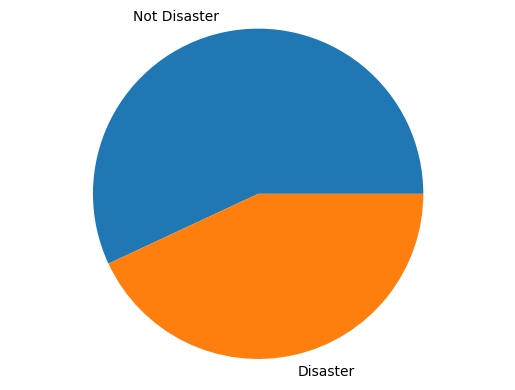

In [ ]:
# First let's check how the data is being distributed
plt.pie(y_train.value_counts(), labels=['Not Disaster', 'Disaster'])
plt.axis('equal')
plt.show()

The labels seems really similar, so there's little risk for a part to be over-represented

In [ ]:
# Use the logistic regression for the Word2Vec data that we are being presented
# The suggestion is to use SVC as a baseline, but we can first use this and then
# use the SVC data and try something else
from sklearn.linear_model import LogisticRegression

w2v_lr = LogisticRegression()
w2v_lr.fit(X_word2vec_train, y_train)


LogisticRegression()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, ConfusionMatrixDisplay
# Method to show metrics
def show_metrics(model, X, y):
  pred = model.predict(X)
  print(f"{model} acc: %.2f prec: %.2f recall: %.2f f1: %.2f" % (accuracy_score(y, pred), precision_score(y, pred), recall_score(y, pred), f1_score(y, pred)))
  print(f"{confusion_matrix(y, pred)}")

Training Set
LogisticRegression() acc: 0.82 prec: 0.84 recall: 0.73 f1: 0.78
[[3093  375]
 [ 718 1904]]
Dev Set
LogisticRegression() acc: 0.80 prec: 0.80 recall: 0.70 f1: 0.75
[[758 116]
 [192 457]]


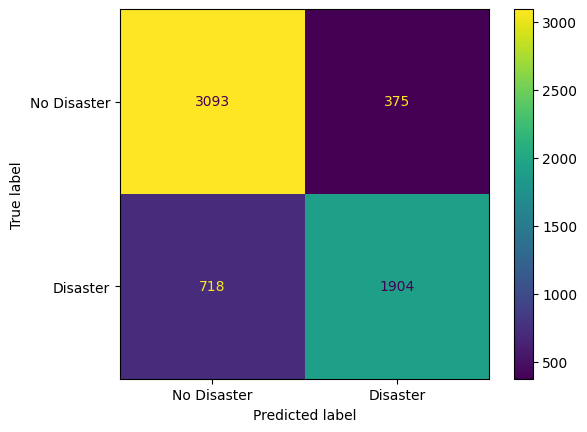

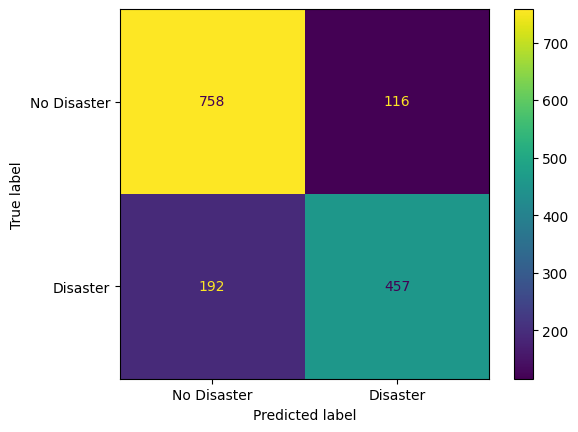

In [ ]:
# Predict the data and show the confustion matrix
print("Training Set")
show_metrics(w2v_lr, X_word2vec_train, y_train)
print("Dev Set")
show_metrics(w2v_lr, X_word2vec_test, y_test)
ConfusionMatrixDisplay.from_estimator(w2v_lr, X_word2vec_train, y_train, display_labels=["No Disaster", "Disaster"])
ConfusionMatrixDisplay.from_estimator(w2v_lr, X_word2vec_test, y_test, display_labels=["No Disaster", "Disaster"])
plt.show()

We can see that the precision and recall is lower than the SVC sample that we were given, but we still have a pretty good score of 0.78 for the training set and 0.75 for the test set.

In [ ]:
# Let's try using a different classifier, last time I use random forest
from sklearn.ensemble import RandomForestClassifier
w2v_rfc = RandomForestClassifier()
w2v_rfc.fit(X_word2vec_train, y_train)

RandomForestClassifier()

Training Set
RandomForestClassifier() acc: 0.99 prec: 0.99 recall: 0.98 f1: 0.99
[[3443   25]
 [  45 2577]]
Dev Set
RandomForestClassifier() acc: 0.80 prec: 0.83 recall: 0.69 f1: 0.75
[[780  94]
 [204 445]]


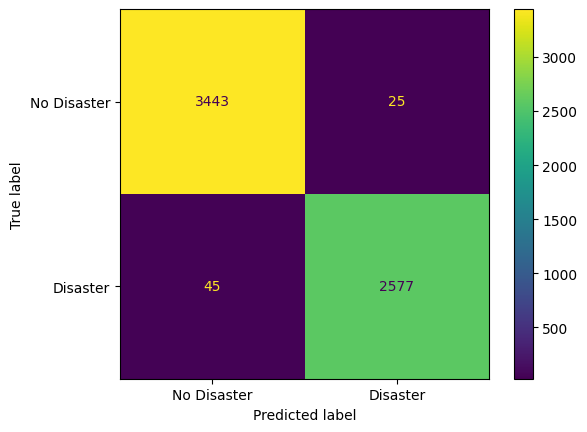

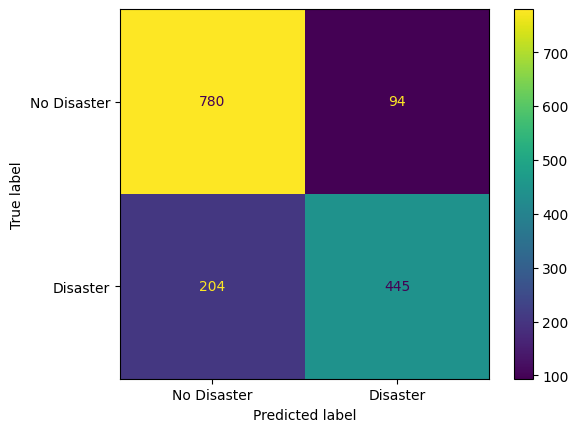

In [ ]:
# Let's show the same metrics that we were showing before
print("Training Set")
show_metrics(w2v_rfc, X_word2vec_train, y_train)
print("Dev Set")
show_metrics(w2v_rfc, X_word2vec_test, y_test)
ConfusionMatrixDisplay.from_estimator(w2v_rfc, X_word2vec_train, y_train, display_labels=["No Disaster", "Disaster"])
ConfusionMatrixDisplay.from_estimator(w2v_rfc, X_word2vec_test, y_test, display_labels=["No Disaster", "Disaster"])
plt.show()

Looks like f1 on the training set it was way better, but in the case of the test set worse, this is expected as the random forest classifier tends to overfit the training data.

Let's print the same metrics for the SVC model

In [ ]:
# Retrain the SVM model so we can see the data in here
w2v_svm = train_svm(X_word2vec_train, y_train)

Training Set
LinearSVC() acc: 0.82 prec: 0.83 recall: 0.74 f1: 0.78
[[3076  392]
 [ 694 1928]]
Dev Set
LinearSVC() acc: 0.80 prec: 0.79 recall: 0.71 f1: 0.75
[[753 121]
 [185 464]]


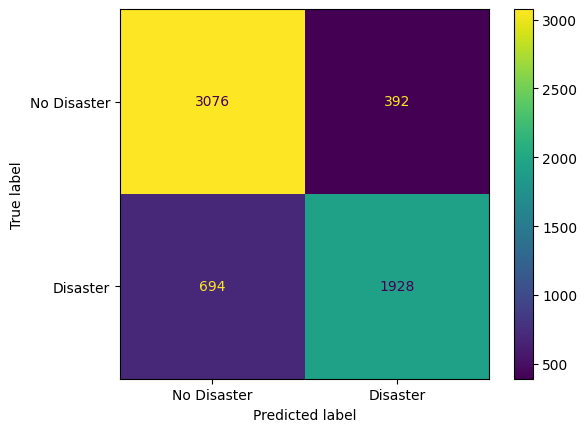

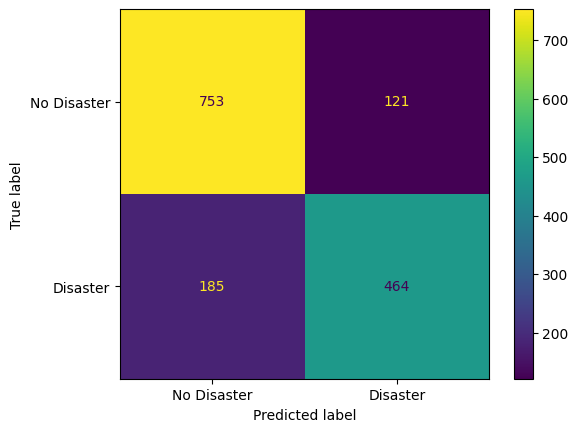

In [ ]:
# Let's show the same metrics that we were showing before
print("Training Set")
show_metrics(w2v_svm, X_word2vec_train, y_train)
print("Dev Set")
show_metrics(w2v_svm, X_word2vec_test, y_test)
ConfusionMatrixDisplay.from_estimator(w2v_svm, X_word2vec_train, y_train, display_labels=["No Disaster", "Disaster"])
ConfusionMatrixDisplay.from_estimator(w2v_svm, X_word2vec_test, y_test, display_labels=["No Disaster", "Disaster"])
plt.show()

Let's try and explore a non linear SVC more as we were using the linear version on the example

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
w2v_nl_svc = SVC()
w2v_nl_svc.fit(X_word2vec_train, y_train)

SVC()

Training Set
SVC() acc: 0.86 prec: 0.91 recall: 0.76 f1: 0.83
[[3261  207]
 [ 619 2003]]
Dev Set
SVC() acc: 0.82 prec: 0.84 recall: 0.73 f1: 0.78
[[784  90]
 [178 471]]


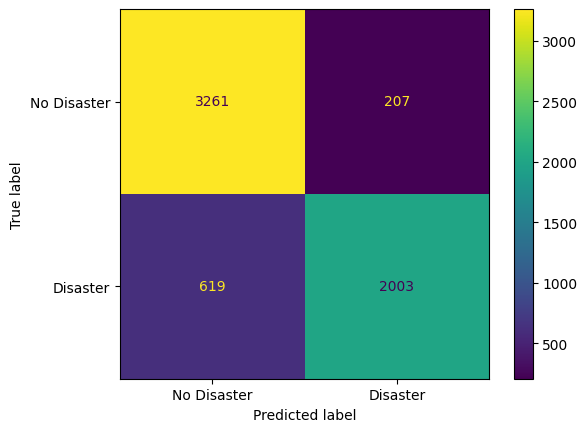

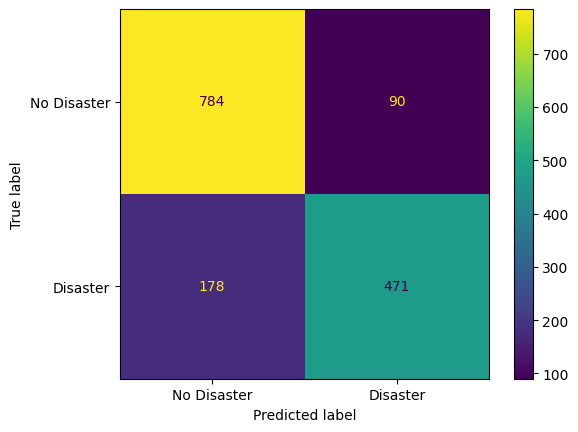

In [ ]:
# Now let's show the metrics for this classificator, this classificator seems
# to not scale with a lot of examples, so we need to take that into account
# when designing the production model, we might need to use SGDClassifier

# Let's show the same metrics that we were showing before
print("Training Set")
show_metrics(w2v_nl_svc, X_word2vec_train, y_train)
print("Dev Set")
show_metrics(w2v_nl_svc, X_word2vec_test, y_test)
ConfusionMatrixDisplay.from_estimator(w2v_nl_svc, X_word2vec_train, y_train, display_labels=["No Disaster", "Disaster"])
ConfusionMatrixDisplay.from_estimator(w2v_nl_svc, X_word2vec_test, y_test, display_labels=["No Disaster", "Disaster"])
plt.show()

We have some really good performance with this classificator, let's try and improve it changing some hyperparameters using a randomized search

In [ ]:
from sklearn.model_selection import GridSearchCV
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
w2v_svc_grid = GridSearchCV(SVC(), param_grid, scoring='f1', n_jobs=-1)
w2v_svc_grid.fit(X_word2vec_train, y_train)
print(w2v_svc_grid.best_params_)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


We see that the best parameters are:
`{'C': 1, 'gamma': 1, 'kernel': 'rbf'}` so we will use those for our **evaluation**

Training Set
GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='f1') acc: 0.89 prec: 0.93 recall: 0.80 f1: 0.86
[[3299  169]
 [ 528 2094]]
Dev Set
GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='f1') acc: 0.83 prec: 0.85 recall: 0.73 f1: 0.78
[[790  84]
 [178 471]]


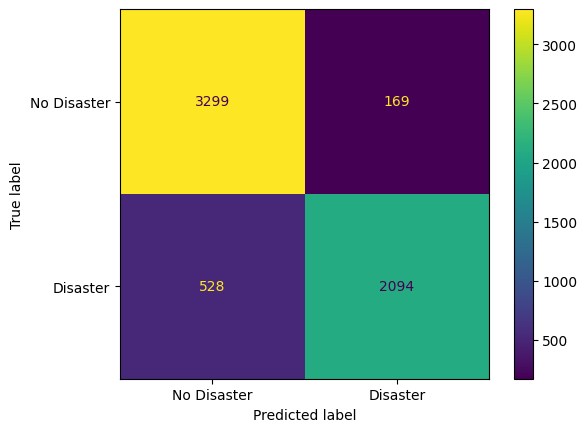

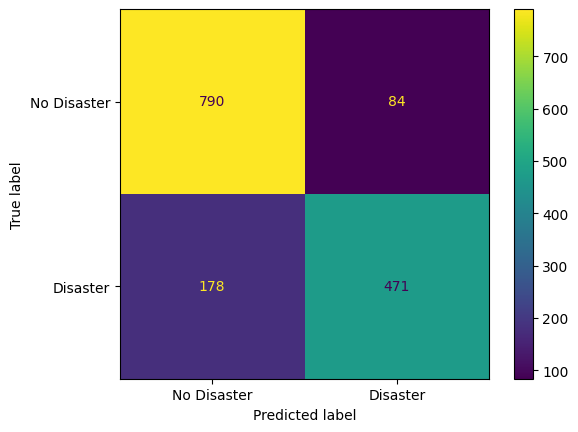

In [ ]:
# Let's show the same metrics that we were showing before
print("Training Set")
show_metrics(w2v_svc_grid, X_word2vec_train, y_train)
print("Dev Set")
show_metrics(w2v_svc_grid, X_word2vec_test, y_test)
ConfusionMatrixDisplay.from_estimator(w2v_svc_grid, X_word2vec_train, y_train, display_labels=["No Disaster", "Disaster"])
ConfusionMatrixDisplay.from_estimator(w2v_svc_grid, X_word2vec_test, y_test, display_labels=["No Disaster", "Disaster"])
plt.show()

Overall we don't see a big improvement after using the SVC model, but we can also see that 0.78 in the test set is a great number and definitely better than the linear version of SVC by 3% 

**Working with the Bert dataset, we see that the Twitter implementation has an overall better performance so we can start with that.**

In [ ]:
# Use the LinearSVC as the base model
bert_svm_base = LinearSVC(max_iter=5000)
bert_svm_base.fit(X_bertweet_train, y_train)

LinearSVC(max_iter=5000)

Training Set
LinearSVC(max_iter=5000) acc: 0.86 prec: 0.87 recall: 0.79 f1: 0.83
[[3165  303]
 [ 558 2064]]
Dev Set
LinearSVC(max_iter=5000) acc: 0.82 prec: 0.81 recall: 0.74 f1: 0.78
[[763 111]
 [167 482]]


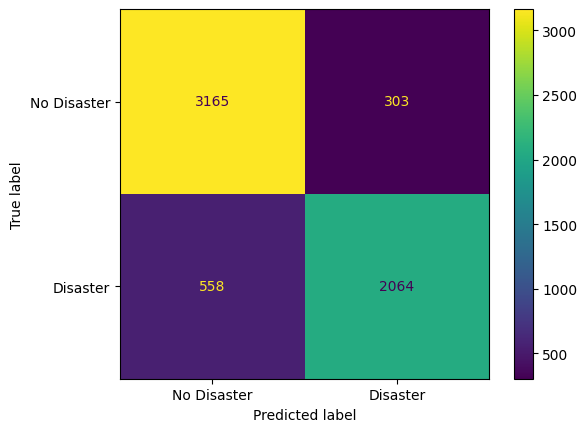

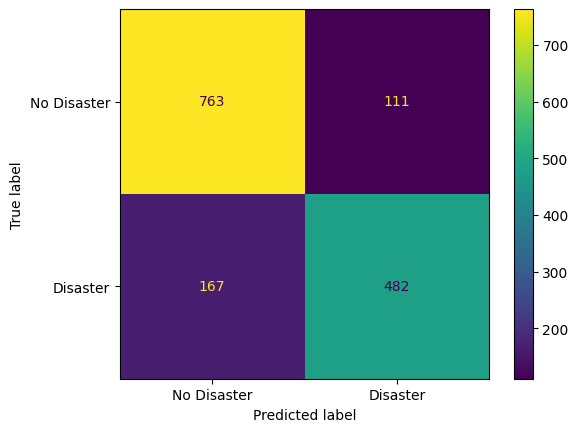

In [ ]:
# Let's show the same metrics that we were showing before
print("Training Set")
show_metrics(bert_svm_base, X_bertweet_train, y_train)
print("Dev Set")
show_metrics(bert_svm_base, X_bertweet_test, y_test)
ConfusionMatrixDisplay.from_estimator(bert_svm_base, X_bertweet_train, y_train, display_labels=["No Disaster", "Disaster"])
ConfusionMatrixDisplay.from_estimator(bert_svm_base, X_bertweet_test, y_test, display_labels=["No Disaster", "Disaster"])
plt.show()

We can see that the Bert version has a similar performace to the one we iterated over on the Word2Vec version, let's see if we can improve it with a non linear version

In [ ]:
# Use the non linear version
from sklearn.svm import SVC
bert_svc = SVC()
bert_svc.fit(X_bertweet_train, y_train)

SVC()

Training Set
SVC() acc: 0.83 prec: 0.87 recall: 0.71 f1: 0.78
[[3197  271]
 [ 756 1866]]
Dev Set
SVC() acc: 0.84 prec: 0.87 recall: 0.72 f1: 0.79
[[805  69]
 [180 469]]


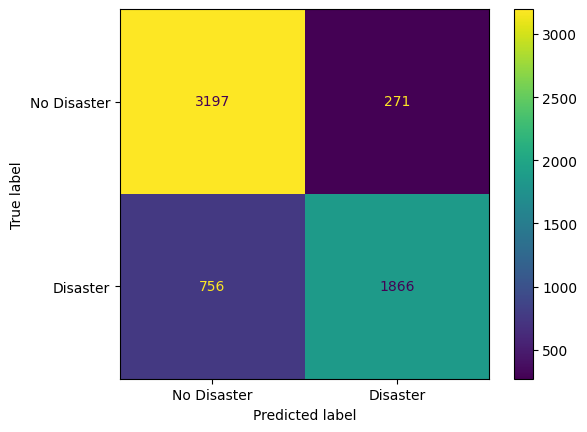

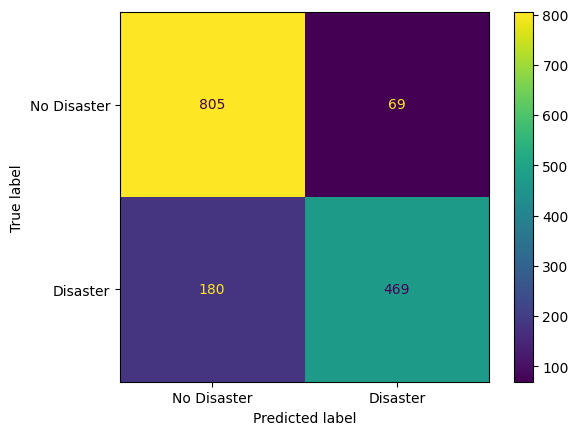

In [ ]:
# Let's show the same metrics that we were showing before
print("Training Set")
show_metrics(bert_svc, X_bertweet_train, y_train)
print("Dev Set")
show_metrics(bert_svc, X_bertweet_test, y_test)
ConfusionMatrixDisplay.from_estimator(bert_svc, X_bertweet_train, y_train, display_labels=["No Disaster", "Disaster"])
ConfusionMatrixDisplay.from_estimator(bert_svc, X_bertweet_test, y_test, display_labels=["No Disaster", "Disaster"])
plt.show()

Training set was definitely affected, but we got an improvement on the test set. Based on this we might want to go with another version like RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
bert_rfc = RandomForestClassifier()
bert_rfc.fit(X_bertweet_train, y_train)

RandomForestClassifier()

Training Set
SVC() acc: 0.83 prec: 0.87 recall: 0.71 f1: 0.78
[[3197  271]
 [ 756 1866]]
Dev Set
SVC() acc: 0.84 prec: 0.87 recall: 0.72 f1: 0.79
[[805  69]
 [180 469]]


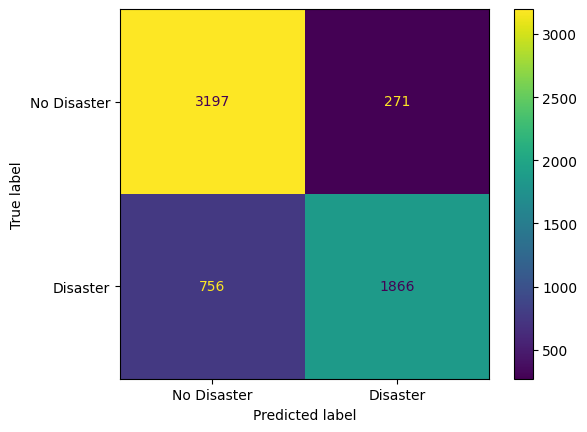

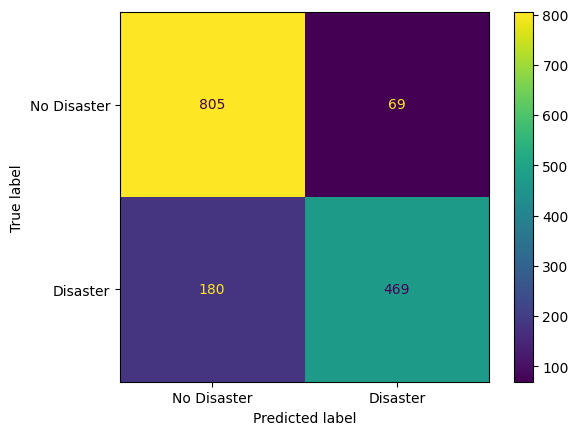

In [ ]:
# Let's show the same metrics that we were showing before
print("Training Set")
show_metrics(bert_svc, X_bertweet_train, y_train)
print("Dev Set")
show_metrics(bert_svc, X_bertweet_test, y_test)
ConfusionMatrixDisplay.from_estimator(bert_svc, X_bertweet_train, y_train, display_labels=["No Disaster", "Disaster"])
ConfusionMatrixDisplay.from_estimator(bert_svc, X_bertweet_test, y_test, display_labels=["No Disaster", "Disaster"])
plt.show()

Random forest seems to have the same issue. Let's dig deeper on the linear model and try to find an improvement on there.

In [ ]:
from sklearn.model_selection import GridSearchCV
# defining parameter range
param_grid = {'C': [0.47, 0.48, 0.49], 
              'loss': ['hinge'], 
              'max_iter': [30000]}
bert_svc_grid = GridSearchCV(LinearSVC(), param_grid, scoring='f1', n_jobs=-1)
bert_svc_grid.fit(X_bertweet_train, y_train)
print(bert_svc_grid.best_params_)

{'C': 0.49, 'loss': 'hinge', 'max_iter': 30000}


Looks like the best parameters are: `{'C': 0.49, 'loss': 'hinge', 'max_iter': 30000}` so let's get some data from that

Training Set
GridSearchCV(estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.47, 0.48, 0.49], 'loss': ['hinge'],
                         'max_iter': [30000]},
             scoring='f1') acc: 0.85 prec: 0.87 recall: 0.76 f1: 0.81
[[3179  289]
 [ 641 1981]]
Dev Set
GridSearchCV(estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.47, 0.48, 0.49], 'loss': ['hinge'],
                         'max_iter': [30000]},
             scoring='f1') acc: 0.83 prec: 0.85 recall: 0.74 f1: 0.79
[[789  85]
 [171 478]]


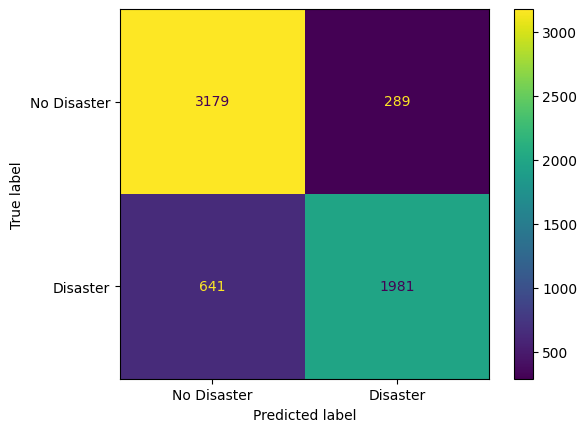

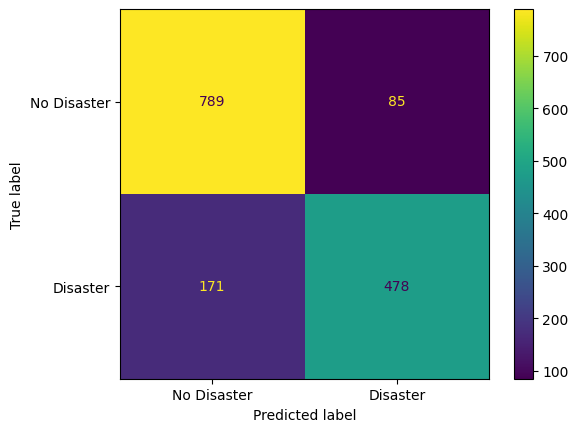

In [ ]:
# Let's show the same metrics that we were showing before
print("Training Set")
show_metrics(bert_svc_grid, X_bertweet_train, y_train)
print("Dev Set")
show_metrics(bert_svc_grid, X_bertweet_test, y_test)
ConfusionMatrixDisplay.from_estimator(bert_svc_grid, X_bertweet_train, y_train, display_labels=["No Disaster", "Disaster"])
ConfusionMatrixDisplay.from_estimator(bert_svc_grid, X_bertweet_test, y_test, display_labels=["No Disaster", "Disaster"])
plt.show()

Looks like a linear model was a better fit with BertTweet, and that was certainly unexpected, but I think that the improvement of the test set and the training set shows that we should go with the linear model even though the training set has a small performance degradation than our base. This just means that we might not be able to improve the model any further.